### Import packages

In [ ]:
import sys
sys.path.append('../')
import numpy as np
from gmm_mi import GMM, GMM_MI
from utils.synthetic_data import D3p
from utils.plotting import plot_contours, plot_MI_values

### Calculate the true MI of the synthetic model, and plot contours

In [ ]:
analytic = D3p.estimate_MI_MC(MC_samples=1e8)
print(analytic)
plot_contours(D3p, ls='-', label="D3'")

### Test on 500 trials

In [3]:
N = 10000
random_states = 500

# parameters to play with
n_inits = 10
n_folds = 5
init_type = 'random_sklearn'
MC_samples = 1e5
tol = 1e-6
reg_covar = 1e-15
max_iter = 10000
MC_samples = 1e5
bootstrap = True
fixed_components = False
n_bootstrap = 100
all_MI_estimates = np.zeros((random_states))

for r in range(random_states):
    
    if r != 195:
        continue
    
    n_components = D3p.n_components 
    true_weights = D3p.weights_
    true_means = D3p.means_
    true_covariances = D3p.covariances_

    X = GMM(n_components=n_components, weights_init=true_weights, 
                      means_init=true_means, covariances_init=true_covariances, 
                      random_state=r+50000).sample(N)[0]

    MI_mean, _, _ = GMM_MI(X, n_folds=n_folds, n_inits=n_inits, 
                                                 init_type=init_type, reg_covar=reg_covar, tol=tol, 
                                                 bootstrap=bootstrap, n_bootstrap=n_bootstrap, MC_samples=MC_samples, 
                                                 fixed_components=fixed_components, fixed_components_number=n_components)
    


    # print for debugging purposes
    print(r, MI_mean) 

    all_MI_estimates[r] = MI_mean

    # save, if needed
    #np.save('./D3p_bias_MI_test.npy', all_MI_estimates)

1 -3.6472087883794506
2 -3.3443917389987936
3 -2.6025571811522674


NameError: name 'ConvergenceWarning' is not defined

### Evaluate MI bias

In [ ]:
# load in case you saved it
#all_MI_estimates = np.load('./D3p_bias_MI_test.npy')

In [ ]:
### then also try this one, but without the +50000 in the seed; also try aic, bic, and longer patience

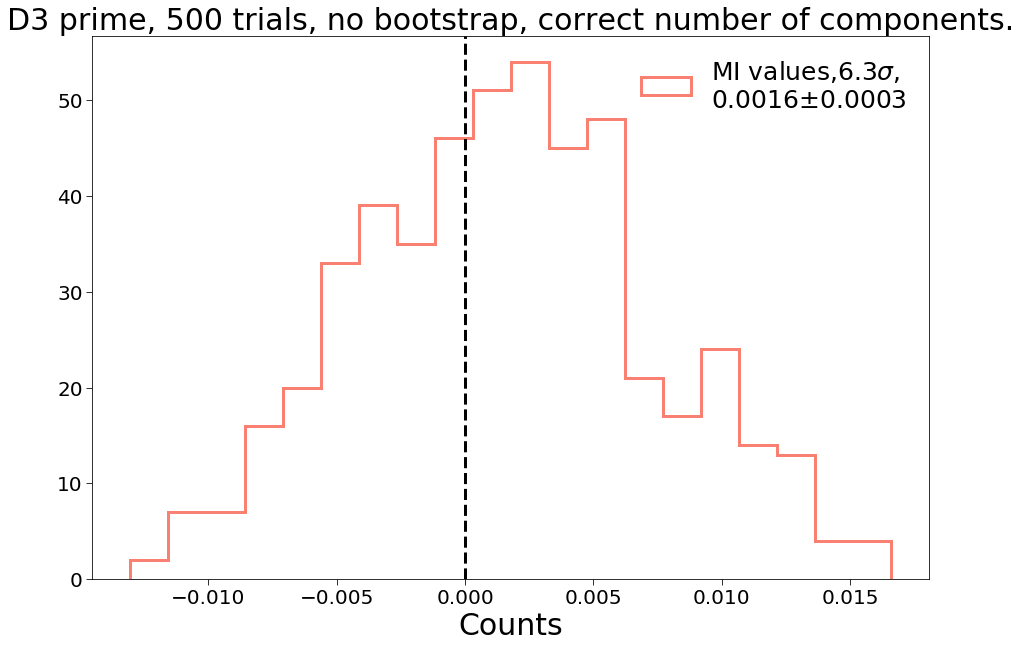

In [7]:
plot_MI_values(all_MI_estimates - analytic, title=f'D3 prime, {random_states} trials, wuth bootstrap, found number of components.')

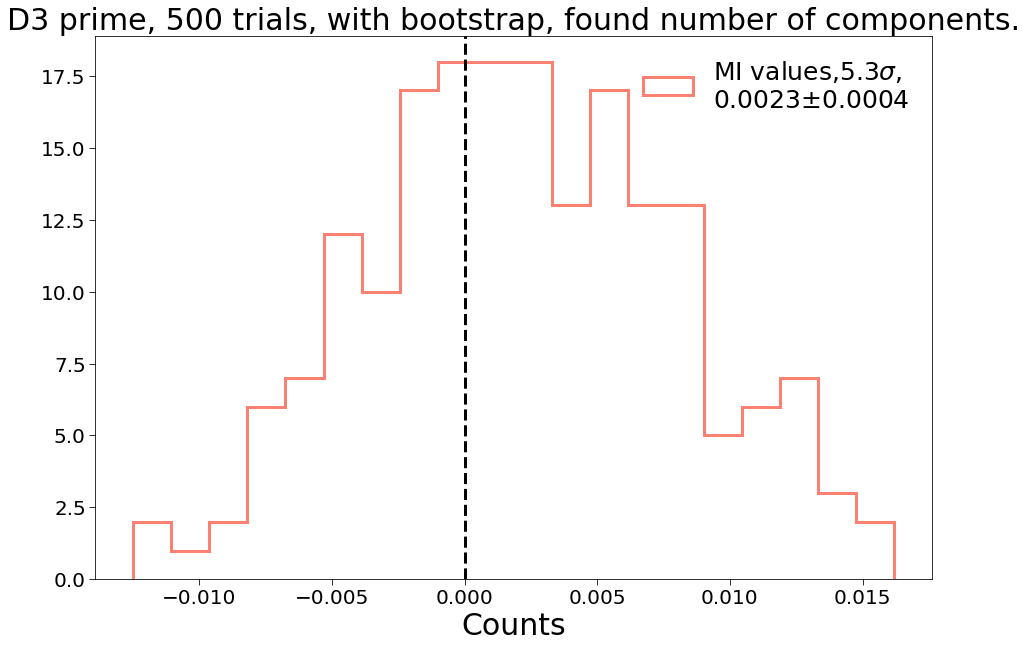

In [11]:
plot_MI_values(all_MI_estimates[:190] - analytic, title=f'D3 prime, {random_states} trials, with bootstrap, found number of components.')